# Diffusion LaSDI-NM Example (MFEM Example 16)

In [1]:
import torch
import torch.nn as nn
import torch.nn.utils.prune as prune
import numpy as np
import numpy.linalg as LA

from scipy import sparse as sp
from scipy import sparse
from scipy.sparse import spdiags
from scipy.sparse import linalg
from scipy.io import savemat,loadmat
import matplotlib.pyplot as plt
import matplotlib.animation as animation 
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
plt.rcParams['figure.dpi'] = 150 
from itertools import combinations_with_replacement, product
from tqdm.notebook import trange, tqdm
import sys,time
import os
import copy
import pickle
sys.path.append("..") # Adds higher directory to python modules path.
from LaSDI import LaSDI

In [2]:
!nvidia-smi
torch.cuda.empty_cache()

Mon Nov 29 13:40:57 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.95.01    Driver Version: 440.95.01    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  On   | 00000004:04:00.0 Off |                    0 |
| N/A   42C    P0    54W / 300W |   7549MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  On   | 00000004:05:00.0 Off |                    0 |
| N/A   46C    P0    52W / 300W |   1753MiB / 16160MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

### Import training simulations, parameters, etc. and NN

In [3]:
# Given parameters
nx = 64
ny = 64
nxy = (ny)*(nx) # 3364
nt = 100
tstop = 1
dt = tstop/nt
m = (ny-2)*(nx-2) # 3364

In [4]:
training_rad = np.arange(80,130,40) 
training_iv = np.arange(180,230,40)
training_values = list(product(training_rad,training_iv))
nset = len(training_values)

In [6]:
snapshot_full = np.empty([nxy, nset*nt]).T
for foo, sample in enumerate(training_values):
    ex = np.load('./data/ex16_w_{}_a_{}.npz'.format(sample[0], sample[1]), allow_pickle = True)
    ex = ex.f.arr_0
    snapshot_full[nt*foo:nt*(foo+1)] = ex

In [7]:
multi_index_i,multi_index_j=np.meshgrid(np.arange(nx),np.arange(ny),indexing='xy')
full_multi_index=(multi_index_j.flatten(),multi_index_i.flatten())
free_multi_index=(multi_index_j[1:-1,1:-1].flatten(),multi_index_i[1:-1,1:-1].flatten())

dims=(ny,nx)
full_raveled_indicies=np.ravel_multi_index(full_multi_index,dims)
free_raveled_indicies=np.ravel_multi_index(free_multi_index,dims)

rescale  = np.amax(snapshot_full)
snapshot_full = snapshot_full[:,free_raveled_indicies]/rescale



[xv,yv]=np.meshgrid(np.linspace(0,1,nx),np.linspace(0,1,ny),indexing='xy')
x=xv.flatten()
y=yv.flatten()

x_free=x[free_raveled_indicies]
y_free=y[free_raveled_indicies]

In [14]:
LS_dim = 4
# Choose device that is not being used
gpu_ids = "1"
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   # see issue #152
os.environ["CUDA_VISIBLE_DEVICES"]=gpu_ids

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device, '\n')

model = torch.load('./model/ex16_AE_git.tar'.format(LS_dim), map_location=device)    

maxk = 10
convergence_threshold = 1.0e-8

t = np.linspace(0, tstop, nt)

# set the number of nodes in each layer
a = 2
b = int(100)
db = int(10)

M1 = int(a*m) # encoder hidden layer
M2 = b + (m-1)*db # decoder hidden layer
f = LS_dim


def create_mask_2d(m,b,db):

    # local
    Mb=sp.diags([np.ones(nx-2),np.ones(nx-2),np.ones(nx-2)],[0,-1,1],(nx-2,nx-2))
    M=sp.kron(sp.eye(ny-2),Mb,format="csr")

    Ib=sp.eye(nx-2)
    N=sp.kron(sp.diags([np.ones(ny-2),np.ones(ny-2),np.ones(ny-2)],[0,-1,1],(ny-2,ny-2)),Ib,format="csr")

    local=(M+N).astype('int8')
    I,J,V=sp.find(local)
    local[I,J]=1

    # basis
    M2 = int(b + db*(m-1))
    basis = np.zeros((m,M2),dtype='int8')

    block = np.ones(b,dtype='int8')
    ind = np.arange(b)
    for row in range(m):
        col = ind + row*db
        basis[row,col] = block

    # mask
    col_ind=np.array([],dtype='int8')
    row_ind=np.array([],dtype='int8')
    for i in range(m):
        col=basis[sp.find(local[i])[1]].sum(axis=0).nonzero()[0]
        row=i*np.ones(col.size)

        col_ind=np.append(col_ind,col)
        row_ind=np.append(row_ind,row)

    data=np.ones(row_ind.size,dtype='int8')
    mask=sp.csr_matrix((data,(row_ind,col_ind)),shape=(m,M2)).toarray()

    print(
        "Sparsity in {} by {} mask: {:.2f}%".format(
            m, M2, (1.0-np.count_nonzero(mask)/np.prod(mask.shape))*100
        )
    )


    return mask



class Encoder(nn.Module):
    def __init__(self,m,M1,f):
        super(Encoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(m,M1),
            nn.Sigmoid(),
            nn.Linear(M1,f,bias=False)
        )

    def forward(self, y):     
        y = y.view(-1,m)
        T = self.full(y)
        T = T.squeeze()

        return T

class Decoder(nn.Module):
    def __init__(self,f,M2,m):
        super(Decoder,self).__init__()
        self.full = nn.Sequential(
            nn.Linear(f,M2),
            nn.Sigmoid(),
            nn.Linear(M2,m,bias=False)
        )

    def forward(self,T):
        T = T.view(-1,f)
        y = self.full(T)
        y = y.squeeze()

        return y

encoder = Encoder(m,M1,f).to(device)
decoder = Decoder(f,M2,m).to(device)
# Prune
mask_2d=create_mask_2d(m,b,db)
prune.custom_from_mask(decoder.full[2], name='weight', mask=torch.tensor(mask_2d).to(device))  

loss_func = nn.MSELoss(reduction='mean')

encoder.load_state_dict(model['encoder_state_dict'])
decoder.load_state_dict(model['decoder_state_dict'])

Using device: cuda 

Sparsity in 3844 by 38530 mask: 99.18%


<All keys matched successfully>

### Generate latent-space trajectories for training simulations

In [16]:
P = list(product(training_rad, training_iv))
P = np.array(P)


latent_space_SS = []

for foo in range(len(P)):
    input_SS=torch.tensor(snapshot_full[foo*(nt+1):(foo+1)*(nt+1)].astype('float32')).to(device)
    latent_space = encoder(input_SS).cpu().detach().numpy()
    latent_space_SS.append(latent_space)

### Generate LaSDI-NM Model

In [ ]:
degree = 1
LaSDI_model = LaSDI(encoder, decoder, NN = True, device = 'cuda')
LaSDI_model.train_dynamics(latent_space_SS, P, dt, degree = degree, normal = 60, include_interaction = True)

### Generate ROM and visualize results

In [23]:
FOM = np.load('./data/ex16_a_{}_w_{}.npz'.format(100,200), allow_pickle = True)
FOM = FOM.f.arr_0/rescale
FOM = FOM[:, free_raveled_indicies]
time_start = time.time()
FOM_recon = LaSDI_model.generate_ROM(FOM[0], [100,200],t)
LaSDI_time = time.time()-time_start

In [25]:
FOM_re = np.empty(nt)
for j in range(nt):
    FOM_re[j] = LA.norm(FOM_recon[j]-FOM[j])/LA.norm(FOM[j])
max_re = np.amax(FOM_re)*100
speed_up = 4.7/LaSDI_time # Given as average time over multiple simulations on Lassen HPC.

Text(0.5, 1.0, 'Absolute Error')

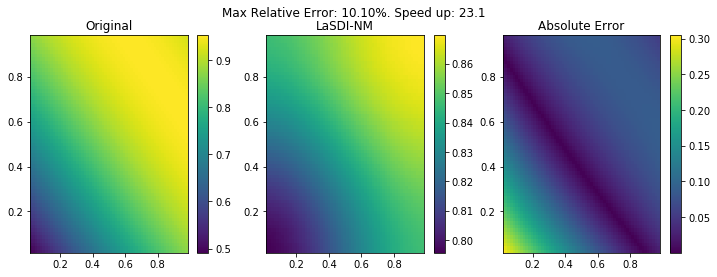

In [26]:
k=-1
fig = plt.figure()
ax1 = fig.add_subplot(1,3,1)
ax2 = fig.add_subplot(1,3,2)
fig.set_size_inches(12,4)
z1=ax1.pcolormesh(x_free.reshape(nx-2,ny-2), y_free.reshape(nx-2,ny-2),FOM[k].reshape(nx-2,ny-2), shading = 'nearest')
fig.suptitle('Max Relative Error: {:.2f}%. Speed up: {:.1f}'.format(np.amax(max_re), speed_up))
fig.colorbar(z1, ax = ax1)
# ax1.axis('equal')
ax1.set_title('Original')
z1=ax2.pcolormesh(x_free.reshape(nx-2,ny-2), y_free.reshape(nx-2,ny-2),FOM_recon[k].reshape(nx-2,ny-2), shading = 'nearest')
fig.colorbar(z1, ax = ax2)
# ax2.axis('equal')
ax2.set_title('LaSDI-NM')
ax3 = fig.add_subplot(1,3,3)
z1=ax3.pcolormesh(x_free.reshape(nx-2,ny-2), y_free.reshape(nx-2,ny-2),np.abs(FOM_recon[k].reshape(nx-2,ny-2)-FOM[k].reshape(nx-2,ny-2)).LA.norm(FOM[k].reshape(nx-2,ny-2)), shading = 'nearest')
fig.colorbar(z1, ax = ax3)
# ax3.axis('equal')
ax3.set_title('Relative Error')

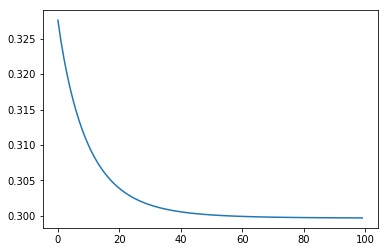

In [19]:
fig = plt.figure()
fig.suptitle('Relative Error for FOM reconstruction via LaSDI-NM')
ax = plt.axes()
ax.set_title('Max Relative Error: {:.3}%'.format(np.amax(FOM_RE)))
ax.plot(t, FOM_RE)
ax.set_xlabel('Time')
ax.set_ylabel('Relative Error (%)')